# SVM Model Classifier on HIGGS Dataset

This notebook aims to evaluate various SVM models on the HIGGS dataset, employing techniques such as feature selection, data normalization, hyperparameter tuning, and sensitivity analysis. The dataset is sampled and processed to prepare it for model training and evaluation.

## Importing Essential Libraries

First, we import the necessary libraries for data manipulation, visualization, and machine learning model evaluation.


In [1]:
# Importing essential libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold, 
    cross_validate, 
    RandomizedSearchCV, 
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    make_scorer
)
from sklearn.calibration import CalibratedClassifierCV
from lime import lime_tabular
from scipy.stats import zscore
import time
import random

# Note: Use '!pip install <package_name>' in case any of these packages are not installed

# Data Preparation and Sampling

In this section, we will prepare the HIGGS dataset for analysis by performing the following steps:

1. **Loading the Dataset**: We will load the dataset from a CSV file named `HIGGS.csv`.

2. **Sampling**: To reduce the dataset size for quicker processing and analysis, we will take a random sample of 0.05% of the data.

3. **Exploring the Data**: We will check the shape of the dataset after sampling and provide a statistical summary of the features. Additionally, we will check for any missing values.

4. **Defining Features and Target**: We will separate the features (input variables) and the target variable (output) for our analysis.


In [2]:
# Make sure 'HIGGS.csv' is present in the working directory
data = pd.read_csv('HIGGS.csv', header=None)
data = data.sample(frac = 0.002, random_state = 71)

# Shape after sampling
print(f"Data shape after sampling: {data.shape}")

# Checking basic information
print(data.describe())

# Checking for missing values
print(data.isnull().sum())

# Features and target
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

Data shape after sampling: (22000, 29)
                 0             1             2             3             4   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.531409      0.991236      0.003461     -0.009175      0.996819   
std        0.499024      0.558237      1.009316      1.001981      0.597563   
min        0.000000      0.274697     -2.425236     -1.742508      0.007365   
25%        0.000000      0.593498     -0.733453     -0.879699      0.574981   
50%        1.000000      0.855018      0.000920     -0.017442      0.894342   
75%        1.000000      1.232749      0.743084      0.854348      1.288208   
max        1.000000      6.073157      2.429998      1.742681      6.017124   

                 5             6             7             8             9   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.000482      0.990177      0.006417      0.010208      1.004850   
std        1

# Feature Analysis and Selection

In this section, we perform a comprehensive analysis and selection of features from our dataset. We start by visualizing the distributions of the features using histograms, which helps us understand the underlying distribution and identify potential anomalies. Subsequently, we use box plots to detect outliers in the features, giving us insight into any extreme values that may affect our model's performance.

To ensure that our features are on a similar scale, we apply data normalization using `StandardScaler`, which standardizes the features by removing the mean and scaling to unit variance. After normalization, we enhance our feature set by creating polynomial and interaction features using `PolynomialFeatures`, which allows us to capture more complex relationships between the features by including terms up to the second degree.

Finally, we implement feature selection using `SelectKBest` to retain the top 15 most significant features based on their relevance to the target variable. This process results in a more manageable and potentially more informative feature set for subsequent modeling. Throughout the process, we display the shapes of the feature sets at various stages to illustrate the changes in dimensionality, enhancing our understanding of the dataset's structure.


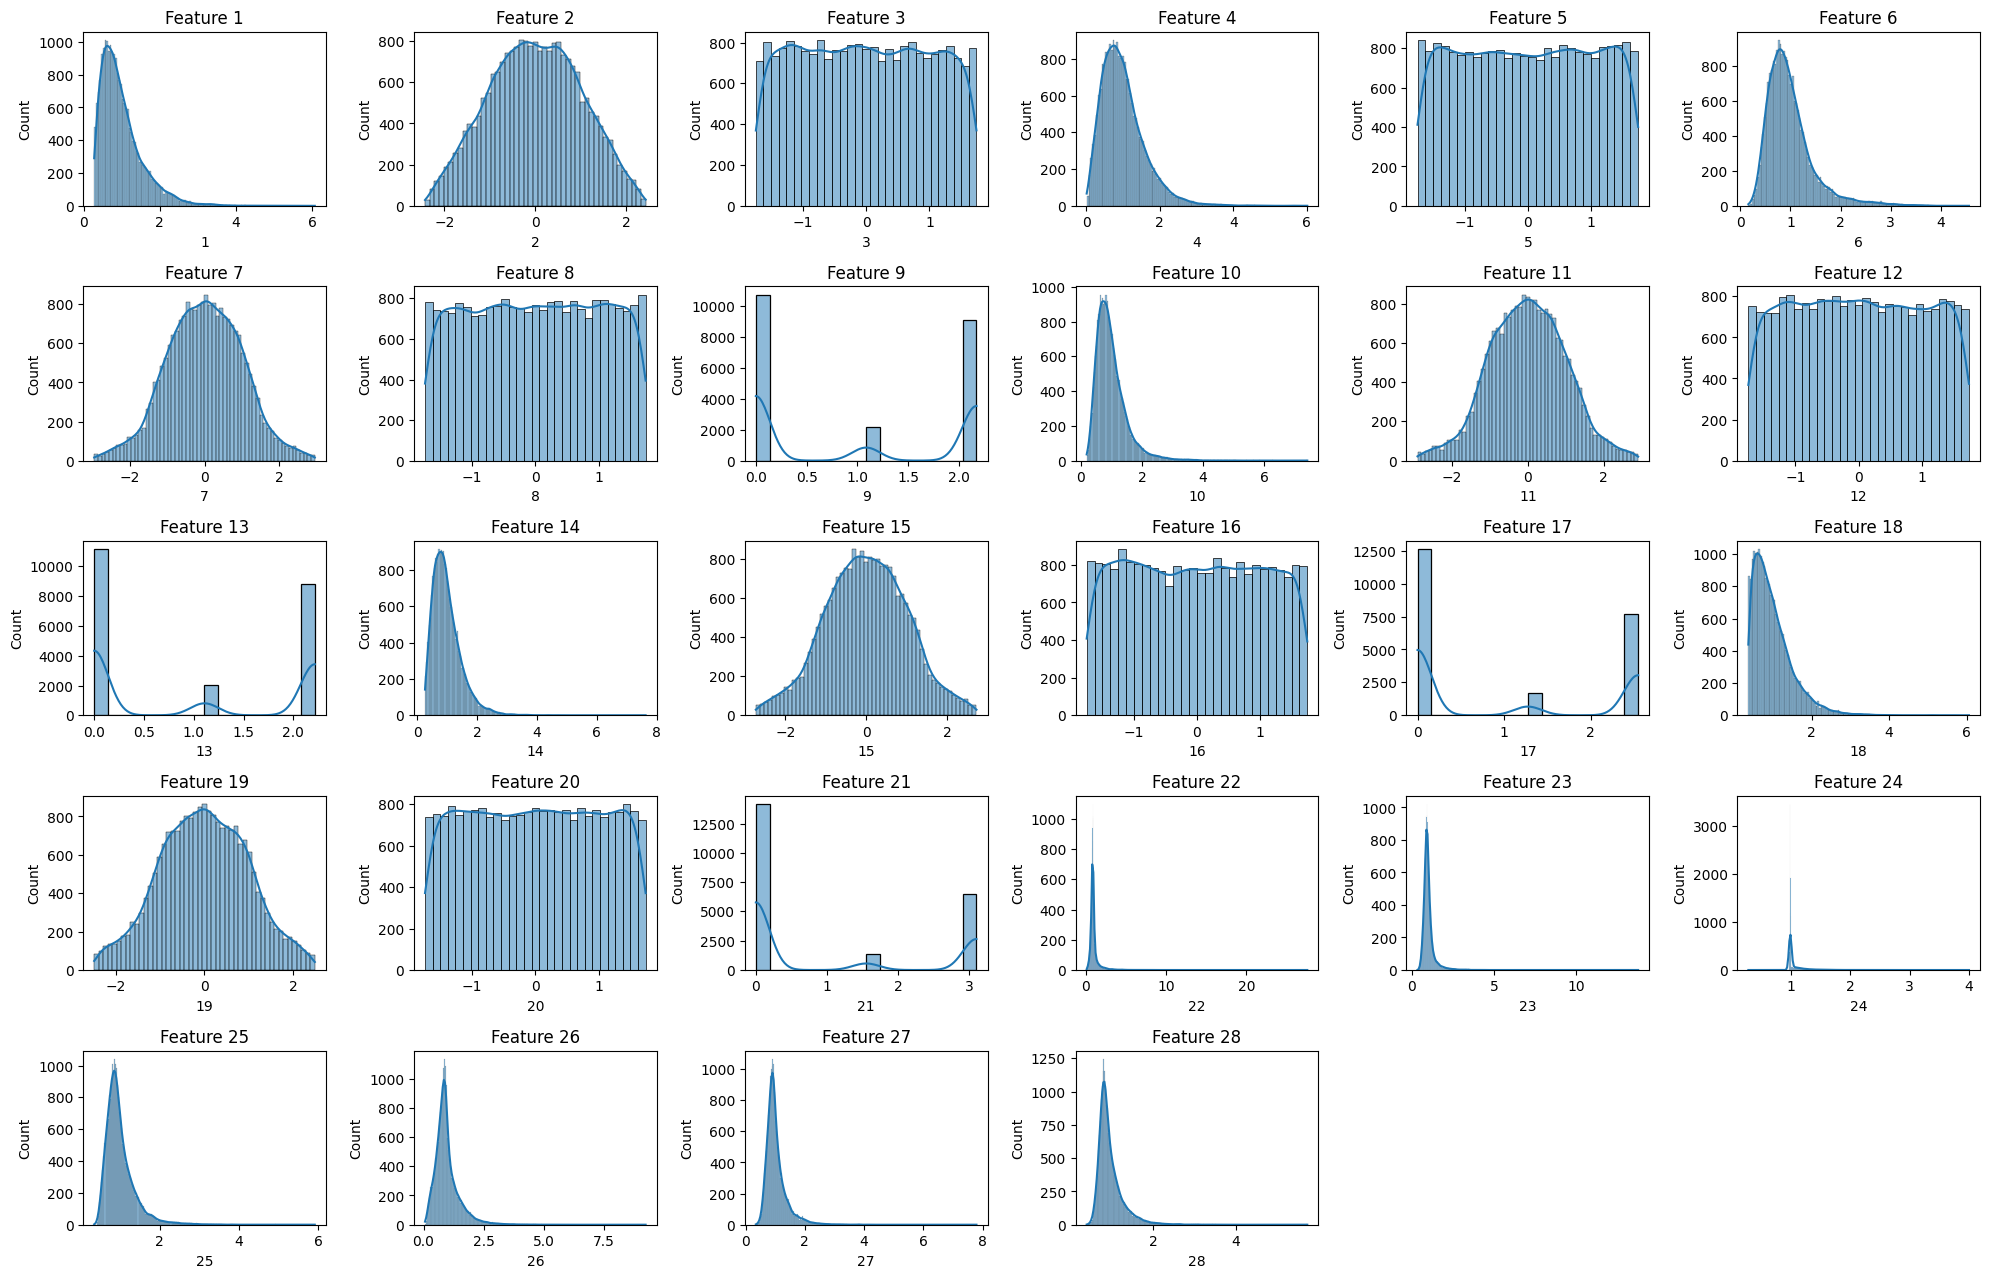

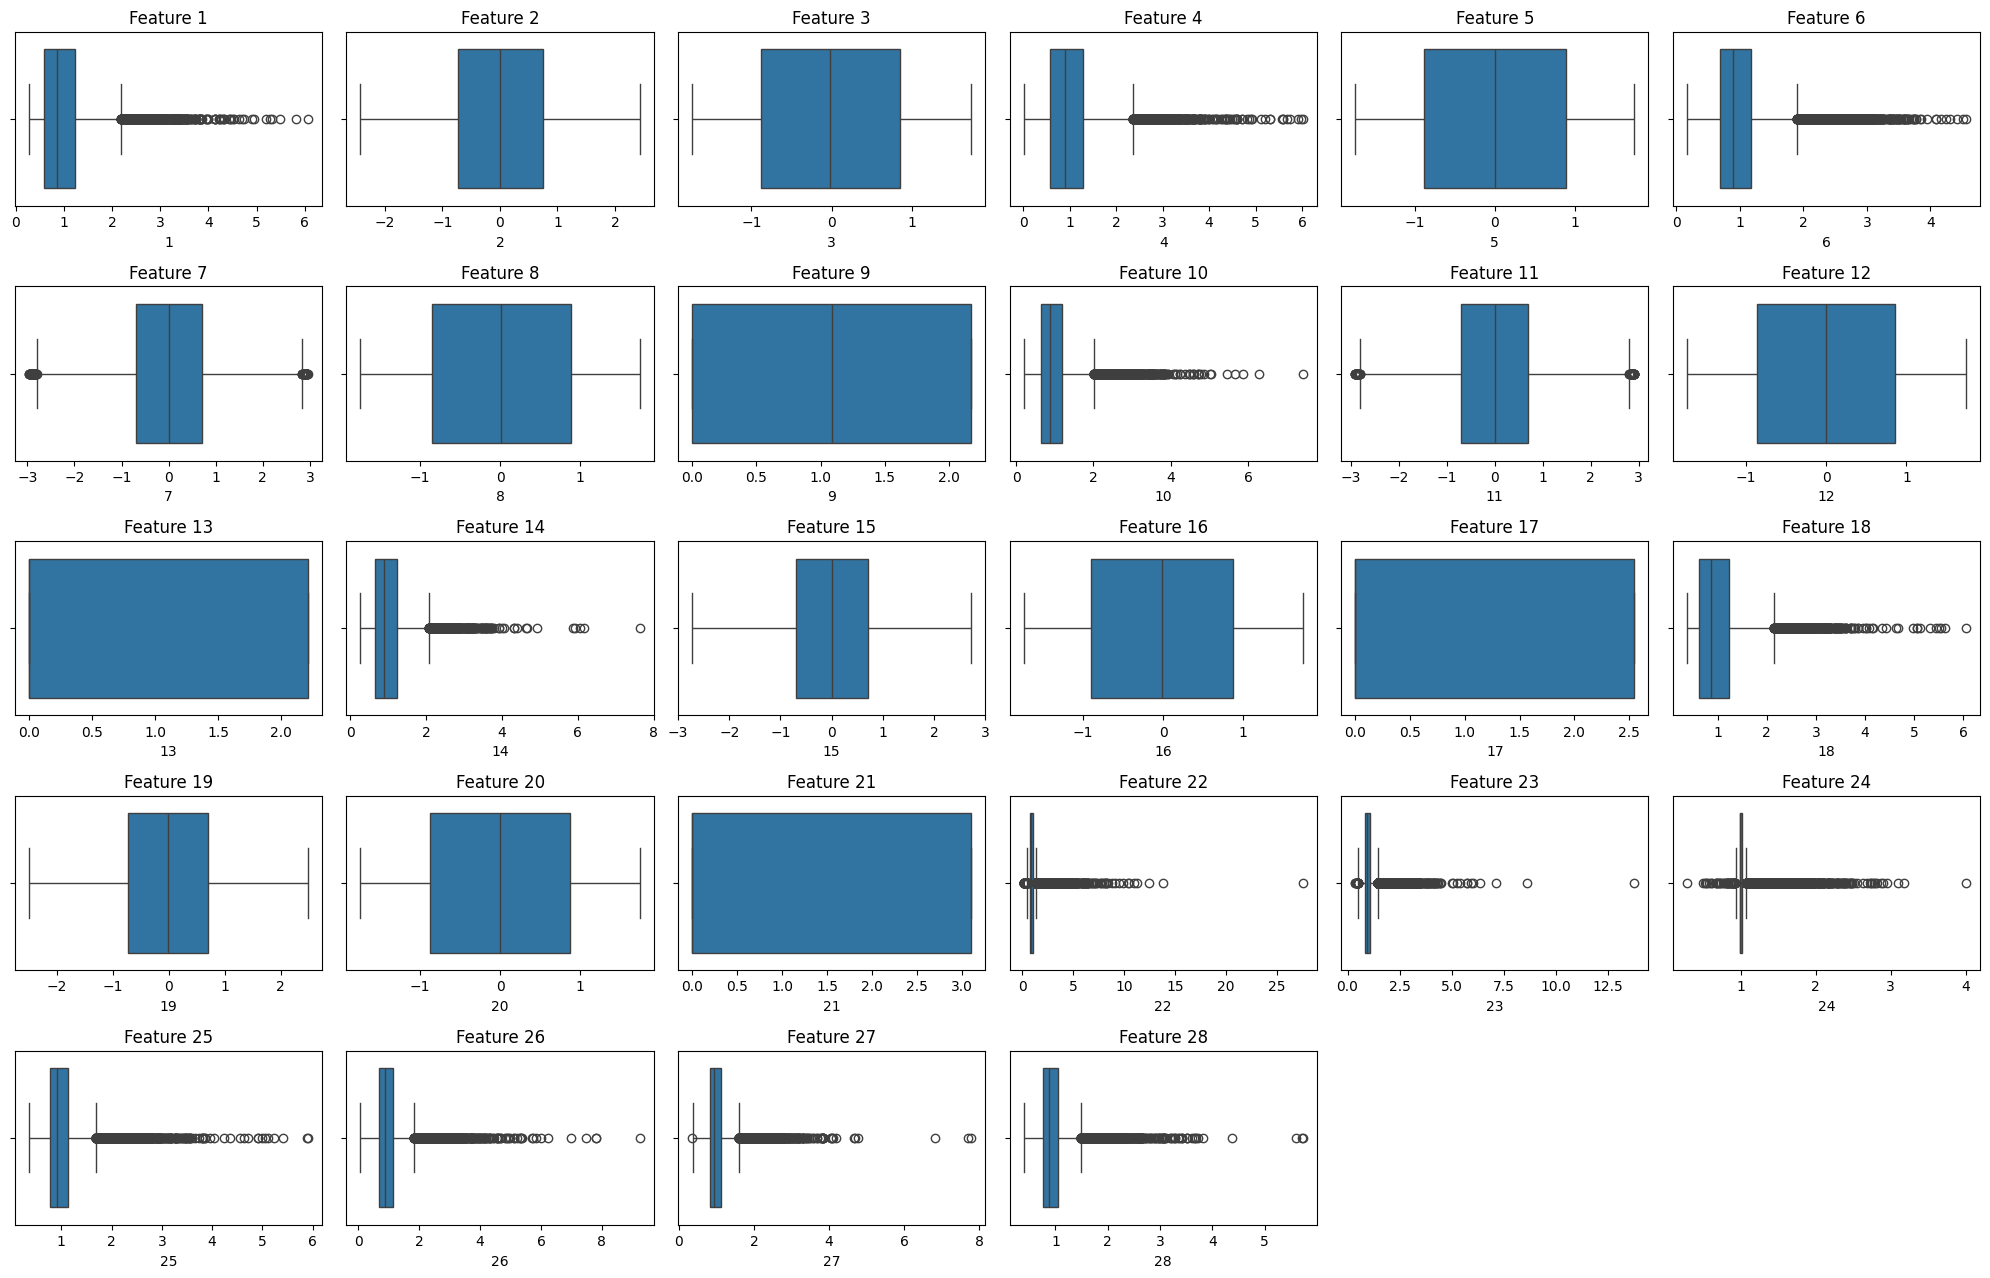

Original features shape: (22000, 28)
Polynomial features shape: (22000, 406)
Selected features shape (SelectKBest): (22000, 15)


In [3]:
# Visualize feature distributions
plt.figure(figsize=(20, 15))
for i in range(1, 29):
    plt.subplot(6, 6, i)
    sns.histplot(X.iloc[:, i-1], kde=True)
    plt.title(f'Feature {i}')
plt.tight_layout()
plt.show()

# Detect outliers using box plots
plt.figure(figsize=(20, 15))
for i in range(1, 29):
    plt.subplot(6, 6, i)
    sns.boxplot(x=X.iloc[:, i-1])
    plt.title(f'Feature {i}')
plt.tight_layout()
plt.show()

# Data Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Feature Selection - Select top 15 features using SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_poly, y)

print(f"Original features shape: {X_scaled.shape}")
print(f"Polynomial features shape: {X_poly.shape}")
print(f"Selected features shape (SelectKBest): {X_selected.shape}")

# Outlier Detection Using Z-scores

Here we have implemented a method to detect outliers in our dataset using the Z-score approach. The Z-score indicates how many standard deviations a data point is from the mean. A Z-score threshold is commonly set to identify outliers, typically at 3 or above, meaning that the data point is more than three standard deviations away from the mean.

We define two functions:

1. **`calculate_z_scores(df)`**: This function calculates the absolute Z-scores for all values in the given DataFrame. It uses the `zscore` function from the `scipy.stats` module to standardize the data.

2. **`detect_outliers(df, threshold=3)`**: This function utilizes the Z-scores calculated by the first function to detect outliers based on a specified threshold. It counts the total number of outliers and identifies the rows in the DataFrame that contain these outliers.

The process works as follows:

- We call `detect_outliers(X)` to analyze the feature set `X`, which is our normalized dataset.
- The function returns the total count of outliers detected as well as the specific rows that contain these outliers.

Finally, we print the total number of outliers detected and display the corresponding rows from the dataset.

In [4]:
# Calculate absolute Z-scores for all values in the DataFrame
def calculate_z_scores(df):
    return np.abs(zscore(df))

# Detect outliers based on a Z-score threshold
def detect_outliers(df, threshold=3):
    z_scores = calculate_z_scores(df)
    outliers = z_scores > threshold
    outlier_count = np.sum(outliers, axis=0).sum()
    outlier_rows = df[outliers.any(axis=1)]
    return outlier_count, outlier_rows

outlier_count, outlier_rows = detect_outliers(X)
print(f"Total outliers detected using Z-score method: {outlier_count}")
print(f"Rows with outliers:\n{outlier_rows}")


Total outliers detected using Z-score method: 4913
Rows with outliers:
                1         2         3         4         5         6   \
3910737   0.318802  0.095395  1.460811  3.126199  0.451268  0.884010   
10568141  1.918484  0.484008 -0.017997  2.031443  0.646705  3.123073   
1651350   0.629551 -0.395485  0.082536  1.074107  0.844387  3.726490   
4998619   2.079715  0.752824  0.948675  1.396053  0.032446  1.230010   
2426838   1.299548  0.124614 -0.440801  1.105363 -1.089664  0.965265   
...            ...       ...       ...       ...       ...       ...   
10602382  2.720064  1.068390 -1.732521  0.278498 -1.101835  1.076843   
5525634   1.722299 -0.941882  1.436398  1.278022 -0.906390  0.741194   
7544025   2.867569 -0.647743  1.392564  0.338450  1.105062  1.755011   
3992473   0.292998  1.370320 -0.353688  1.025758  1.570523  0.730934   
4157666   0.588374  0.898919  0.140242  0.512521  1.657642  1.396002   

                7         8         9         10  ...        19 

# Model Evaluation with Scoring Metrics

In this section, we will define scoring metrics for model evaluation and implement a function to evaluate a Linear Support Vector Machine (SVM) model using cross-validation.

### Scoring Metrics Definition

We create a function called **`define_scoring_metrics()`** that returns a dictionary of common evaluation metrics used in classification tasks. The metrics included are:

- **Accuracy**: The proportion of true results among the total number of cases examined.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives, indicating the quality of the positive class predictions.
- **Recall**: The ratio of correctly predicted positive observations to all actual positives, reflecting the model's ability to find all relevant cases.
- **F1 Score**: The weighted average of Precision and Recall, providing a balance between the two metrics.
- **ROC AUC**: The area under the Receiver Operating Characteristic curve, which measures the model's ability to distinguish between classes.

These metrics are implemented using the `make_scorer` function from the `sklearn.metrics` module.

### Model Evaluation Function

Next, we define the function **`evaluate_model(model, X, y, cv, scoring)`**, which evaluates the provided model using cross-validation. It uses the `cross_validate` function to compute the specified scoring metrics. The function returns the mean scores for each metric across all cross-validation folds.

### Cross-Validation Strategy

We use **`StratifiedKFold`** for cross-validation, which ensures that each fold has the same proportion of class labels as the complete dataset. In this case, we set `n_splits=5` to create 5 folds.

### Model Initialization

We initialize a Linear SVM model using the `SVC` class from `sklearn.svm`, specifying the `kernel='linear'` and enabling `probability=True` to allow for probability estimates necessary for the ROC AUC score.

### Model Evaluation and Results Display

Finally, we call the `evaluate_model` function to assess the Linear SVM model on the selected features (`X_selected`) and the target variable (`y`). The results are printed for each metric, providing insights into the model's performance.

In [5]:
def define_scoring_metrics():
    return {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, response_method="predict_proba")
    }

def evaluate_model(model, X, y, cv, scoring):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    return {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'roc_auc': np.mean(cv_results['test_roc_auc'])
    }

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Define scoring metrics
scoring = define_scoring_metrics()

# Initialize Linear SVM model
linear_svc = SVC(kernel='linear', probability=True)

# Evaluate model and print results
results = evaluate_model(linear_svc, X_selected, y, cv, scoring)
print("Linear SVM Results:")
for metric, score in results.items():
    print(f"{metric.capitalize()}: {score:.4f}")

Linear SVM Results:
Accuracy: 0.5934
Precision: 0.5731
Recall: 0.9203
F1: 0.7064
Roc_auc: 0.6464


# SGD Model Evaluation

In this section, we will initialize and evaluate a Stochastic Gradient Descent (SGD) classifier model using cross-validation. The SGD classifier is particularly useful for large datasets due to its efficiency and ability to handle online learning.

### Model Initialization

We define the function **`initialize_sgd_model()`** to create an instance of the `SGDClassifier` with the following parameters:

- **`loss='hinge'`**: This specifies that we are using the hinge loss, which is appropriate for Support Vector Machines (SVM).
- **`max_iter=1000`**: This sets the maximum number of iterations for the optimization algorithm.
- **`tol=1e-3`**: This is the tolerance for stopping criteria; the algorithm will stop if the improvement is less than this value.
- **`random_state=71`**: This sets the seed for the random number generator, ensuring reproducibility.

To improve the probability estimates of the predictions, we wrap the SGD model in a **`CalibratedClassifierCV`** with the `method='sigmoid'` and a cross-validation strategy (`cv=5`). This helps in calibrating the probabilities produced by the model.

### Model Evaluation

We define the function **`evaluate_sgd_model(model, X, y, cv, scoring)`**, which evaluates the model using cross-validation and returns the average scores for various performance metrics, similar to the previous evaluation function. 

The performance metrics calculated are:

- **Accuracy**: The proportion of true results among the total predictions.
- **Precision**: The accuracy of the positive predictions.
- **Recall**: The ability of the model to identify all relevant instances.
- **F1 Score**: The harmonic mean of precision and recall.
- **ROC AUC**: The area under the ROC curve, reflecting the model's ability to distinguish between classes.

### Model Evaluation and Results Display

After initializing the calibrated SGD SVM model using `initialize_sgd_model()`, we evaluate it using the `evaluate_sgd_model` function with the selected features (`X_selected`) and target variable (`y`). Finally, we print the results for each metric to assess the model's performance.

In [6]:
def initialize_sgd_model():
    sgd_svc = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=71)
    calibrated_sgd_svc = CalibratedClassifierCV(sgd_svc, method='sigmoid', cv=5)
    return calibrated_sgd_svc

def evaluate_sgd_model(model, X, y, cv, scoring):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    return {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'roc_auc': np.mean(cv_results['test_roc_auc'])
    }

# Initialize the Calibrated SGD SVM model
sgd_model = initialize_sgd_model()

# Perform cross-validation and evaluate the model
results_sgd = evaluate_sgd_model(sgd_model, X_selected, y, cv, scoring)

# Print results
print("\nSGD SVM Results:")
for metric, score in results_sgd.items():
    print(f"{metric.capitalize()}: {score:.4f}")



SGD SVM Results:
Accuracy: 0.6058
Precision: 0.5862
Recall: 0.8779
F1: 0.7030
Roc_auc: 0.6440


# Model Evaluation and Hyperparameter Tuning with Grid Search

In this section, we will evaluate the performance of our model using various metrics and conduct a grid search to optimize the hyperparameters for an SVM model with a polynomial kernel.

### Model Evaluation Function

The **`evaluate_model(model, X, y)`** function is defined to compute and display several performance metrics for a given model:

- **Predictions**: The model makes predictions on the input features `X`.
- **Probabilities**: The model also outputs the probabilities of the positive class using the `predict_proba` method.
  
We then compute the following metrics:

- **Accuracy**: The proportion of correct predictions.
- **Precision**: The ratio of true positive predictions to the total predicted positives.
- **Recall**: The ratio of true positive predictions to all actual positives.
- **F1 Score**: The harmonic mean of precision and recall.
- **AUC (Area Under the Curve)**: The area under the ROC curve, measuring the model's ability to distinguish between classes.

These metrics are printed to provide a comprehensive overview of the model's performance.

### Grid Search for Hyperparameter Tuning

The **`perform_grid_search(X, y, degrees, param_grid_base)`** function implements a grid search to find the best hyperparameters for the SVM model with a polynomial kernel. The function takes the following inputs:

- **`X`**: The feature set.
- **`y`**: The target labels.
- **`degrees`**: A list of polynomial degrees to evaluate.
- **`param_grid_base`**: A base parameter grid containing hyperparameters to tune, such as `C` (regularization parameter) and `kernel`.

Within the function:

1. It iterates through the specified polynomial degrees.
2. For each degree, it constructs a parameter grid that includes the current degree.
3. It initializes `GridSearchCV` with the SVM model, the parameter grid, a 5-fold cross-validation strategy, and accuracy as the scoring metric.
4. The grid search is fitted to the data, and the time taken for training is recorded.
5. The best parameters found during the search are printed, along with the training time.

Finally, the best model is evaluated using the **`evaluate_model`** function to display its performance metrics.

### Training and Evaluating Polynomial Kernel SVM Models

To run the polynomial kernel evaluation, we define `X_final` and `y_final` (the final feature set and target labels), and call the `perform_grid_search` function with polynomial degrees `[2, 3, 4]` and a base parameter grid.

### Training and Evaluating RBF Kernel SVM Models

The **`train_rbf_model(X, y, C_values, gamma_values)`** function trains an SVM model with an RBF kernel using specified values for the regularization parameter `C` and the kernel coefficient `gamma`. The process involves:

1. Iterating through different values of `gamma`.
2. Randomly selecting a value for `C` from the provided list.
3. Initializing the SVM model with the RBF kernel and fitting it to the training data.
4. Measuring the training time and printing it.
5. Evaluating the model using the `evaluate_model` function to display the performance metrics.

### Training and Evaluating Sigmoid Kernel SVM Models

Similarly, the **`train_sigmoid_model(X, y, C_values, gamma_values)`** function performs training and evaluation for an SVM model with a Sigmoid kernel. The steps are analogous to those in the RBF model training:

1. Iterating over `gamma` values while randomly selecting `C`.
2. Initializing the SVM model with the Sigmoid kernel.
3. Fitting the model to the training data and measuring the training time.
4. Evaluating the model's performance using the `evaluate_model` function.

### Execution of the Model Training and Evaluation

We define `X_final` and `y_final` to represent the feature set and target labels, and specify the possible values for `C` and `gamma`. Then we call the respective functions to train and evaluate both RBF and Sigmoid kernel SVM models.


In [7]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, probabilities)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

def perform_grid_search(X, y, degrees, param_grid_base):
    for degree in degrees:
        print(f"\nPolynomial Kernel (Degree = {degree})")

        param_grid = param_grid_base.copy()
        param_grid['degree'] = [degree]

        grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')

        start_time = time.time()
        grid_search.fit(X, y)
        end_time = time.time()

        print("Best Parameters:", grid_search.best_params_)
        print(f"Training time: {end_time - start_time:.2f} seconds")

        best_model = grid_search.best_estimator_
        evaluate_model(best_model, X, y)

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Polynomial Kernel Evaluation
degrees = [2, 3, 4]
param_grid_base = {
    'C': [0.1, 1, 10],
    'kernel': ['poly']
}

perform_grid_search(X_final, y_final, degrees, param_grid_base)


Polynomial Kernel (Degree = 2)
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Training time: 2329.07 seconds
Accuracy: 0.6268
Precision: 0.6010
Recall: 0.8862
F1 Score: 0.7162
AUC: 0.7054

Polynomial Kernel (Degree = 3)
Best Parameters: {'C': 10, 'degree': 3, 'kernel': 'poly'}
Training time: 2792.71 seconds
Accuracy: 0.6144
Precision: 0.5858
Recall: 0.9365
F1 Score: 0.7208
AUC: 0.7160

Polynomial Kernel (Degree = 4)
Best Parameters: {'C': 10, 'degree': 4, 'kernel': 'poly'}
Training time: 4204.53 seconds
Accuracy: 0.6086
Precision: 0.5792
Recall: 0.9631
F1 Score: 0.7234
AUC: 0.7135


In [8]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, probabilities)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

def train_rbf_model(X, y, C_values, gamma_values):
    for gamma in gamma_values:
        C = random.choice(C_values)
        print(f"\nRBF Kernel (C = {C}, gamma = {gamma})")

        rbf_svc = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)

        start_time = time.time()
        rbf_svc.fit(X, y)
        end_time = time.time()

        print(f"Training time: {end_time - start_time:.2f} seconds")

        evaluate_model(rbf_svc, X, y)

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Define the possible C values and gamma values
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.001, 1]

# Train and evaluate RBF models
train_rbf_model(X_final, y_final, C_values, gamma_values)



RBF Kernel (C = 0.1, gamma = 0.01)
Training time: 243.57 seconds
Accuracy: 0.6101
Precision: 0.5876
Recall: 0.8927
F1 Score: 0.7087
AUC: 0.6746

RBF Kernel (C = 10, gamma = 0.001)
Training time: 232.35 seconds
Accuracy: 0.6110
Precision: 0.5878
Recall: 0.8966
F1 Score: 0.7101
AUC: 0.6737

RBF Kernel (C = 10, gamma = 1)
Training time: 908.87 seconds
Accuracy: 0.9551
Precision: 0.9426
Recall: 0.9749
F1 Score: 0.9585
AUC: 0.9842


In [9]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, probabilities)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

def train_sigmoid_model(X, y, C_values, gamma_values):
    for gamma in gamma_values:
        C = random.choice(C_values)
        print(f"\nSigmoid Kernel (C = {C}, gamma = {gamma})")

        sigmoid_svc = SVC(kernel='sigmoid', C=C, gamma=gamma, probability=True)

        start_time = time.time()
        sigmoid_svc.fit(X, y)
        end_time = time.time()

        print(f"Training time: {end_time - start_time:.2f} seconds")
        evaluate_model(sigmoid_svc, X, y)

# Ensure X_final and y_final are defined
X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Define the possible C values and gamma values
C_values = [0.1, 1, 10]
gamma_values = [0.001, 0.01, 1]

# Train and evaluate Sigmoid SVM models
train_sigmoid_model(X_final, y_final, C_values, gamma_values)



Sigmoid Kernel (C = 1, gamma = 0.001)
Training time: 160.43 seconds
Accuracy: 0.6067
Precision: 0.5988
Recall: 0.7880
F1 Score: 0.6805
AUC: 0.6097

Sigmoid Kernel (C = 10, gamma = 0.01)
Training time: 96.63 seconds
Accuracy: 0.5281
Precision: 0.5540
Recall: 0.5751
F1 Score: 0.5644
AUC: 0.4627

Sigmoid Kernel (C = 0.1, gamma = 1)
Training time: 173.40 seconds
Accuracy: 0.4707
Precision: 0.5020
Recall: 0.5028
F1 Score: 0.5024
AUC: 0.5340


# Hyperparameter Tuning for SVM Models

Here, we perform hyperparameter tuning for Support Vector Machine (SVM) models using the Polynomial and Radial Basis Function (RBF) kernels. The goal is to identify the optimal parameters that maximize the model's performance, specifically the Area Under the Curve (AUC) score, using cross-validation.

### Hyperparameter Tuning Function

The **`hyperparameter_tuning(kernel_type, param_dist, X, y)`** function utilizes `RandomizedSearchCV` to optimize the hyperparameters of the SVM model. Key steps include:

1. **Initialization**: A Support Vector Classifier (SVC) model is initialized with the specified kernel type and probability estimates enabled.
2. **Randomized Search**: The function searches for the best combination of hyperparameters defined in `param_dist`. It evaluates combinations using cross-validation (`cv=3`) and scores based on the ROC AUC.
3. **Output**: The function returns the best hyperparameters found and the best score achieved during the search.

### Execution of Hyperparameter Tuning

We set `X_final` and `y_final` to represent the feature set and target labels. The tuning process is then conducted for both Polynomial and RBF kernels:

1. **Polynomial Kernel Tuning**: We specify the parameter distribution, including values for `C`, `degree`, and `gamma`. After executing the tuning function, the best parameters and score are printed.
   
2. **RBF Kernel Tuning**: Similarly, we define the parameter distribution for the RBF kernel and execute the tuning function to retrieve and print the best parameters and score.

In [1]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions)
    recall = recall_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    return accuracy, precision, recall, f1, auc

def hyperparameter_tuning(kernel_type, param_dist, X, y):
    svc_model = SVC(kernel=kernel_type, probability=True)
    search = RandomizedSearchCV(svc_model, param_dist, n_iter=10, cv=3, scoring='roc_auc', random_state=71)
    search.fit(X, y)
    best_params = search.best_params_
    best_score = search.best_score_
    return best_params, best_score

X_final = X_selected  # Replace with your final feature set variable if different
y_final = y           # Replace with your target label variable if different

# Hyperparameter tuning for Polynomial Kernel
print("Hyperparameter Tuning for Polynomial Kernel")
poly_param_dist = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
poly_best_params, poly_best_score = hyperparameter_tuning('poly', poly_param_dist, X_final, y_final)
print(f"Best parameters for Polynomial Kernel: {poly_best_params}")
print(f"Best cross-validation AUC score: {poly_best_score:.4f}")

# Hyperparameter tuning for RBF Kernel
print("\nHyperparameter Tuning for RBF Kernel")
rbf_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto']
}
rbf_best_params, rbf_best_score = hyperparameter_tuning('rbf', rbf_param_dist, X_final, y_final)
print(f"Best parameters for RBF Kernel: {rbf_best_params}")
print(f"Best cross-validation AUC score: {rbf_best_score:.4f}")


NameError: name 'X_selected' is not defined

# Sensitivity Analysis for SVM Kernels

This section conducts a sensitivity analysis on Support Vector Machine (SVM) models with Polynomial and Radial Basis Function (RBF) kernels. The objective is to evaluate how changes in specific hyperparameters (C values and kernel-specific parameters) affect the model's performance, measured by the Area Under the Curve (AUC) score using cross-validation.

### Sensitivity Analysis Function

The **`sensitivity_analysis(kernel, X, y, C_values, param_values, param_name, cv_folds=3)`** function performs the following:

1. **Initialization**: An empty list is created to store the results for different parameter combinations.

2. **Model Training and Scoring**:
   - The function iterates through each specified value of the kernel-specific parameter (e.g., `gamma` for RBF and `degree` for Polynomial).
   - For each parameter value, it iterates over the list of `C` values, initializing an SVM model with the given kernel type and the current values of `C` and the specified parameter.
   - The model is evaluated using cross-validation (`cross_val_score`), specifically calculating the mean ROC AUC score, which is appended to the scores list for that parameter value.

3. **Results Compilation**: The results are compiled into a DataFrame, with rows representing the parameter values and columns representing the `C` values.

4. **Visualization**: A heatmap is generated to visualize the performance scores for different combinations of `C` and the specified parameter. This heatmap allows for easy identification of which combinations yield the best performance.

### Execution of Sensitivity Analysis

1. **RBF Kernel Sensitivity Analysis**: We define a list of `C` values and `gamma` values. The sensitivity analysis function is executed for the RBF kernel, and the results are stored in `results_rbf`.

2. **Polynomial Kernel Sensitivity Analysis**: Similarly, we define a list of `C` values and `degree` values. The sensitivity analysis function is executed for the Polynomial kernel, and the results are stored in `results_poly`.

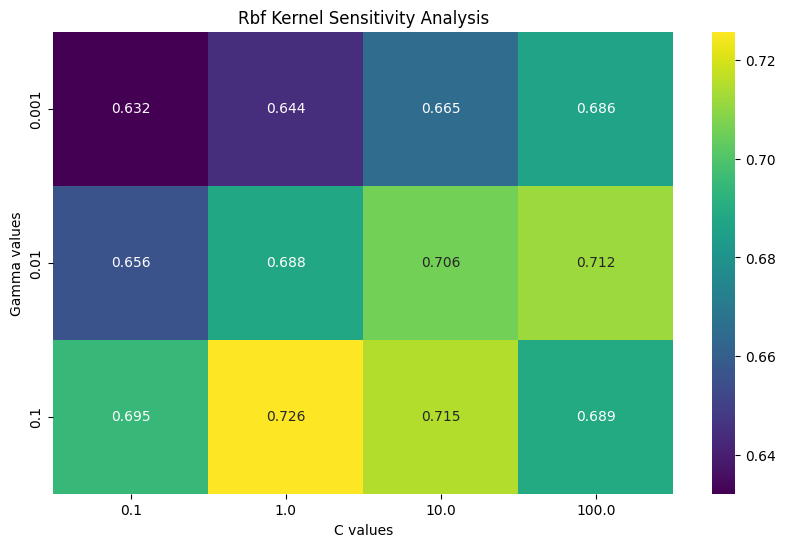

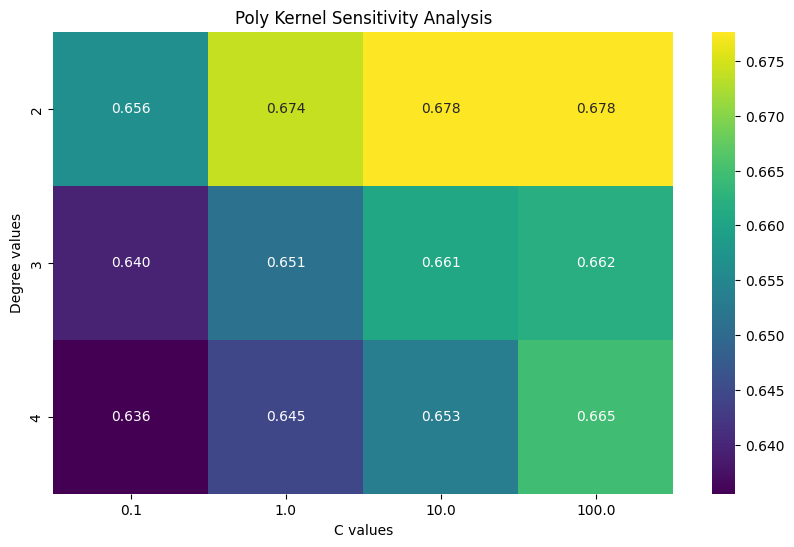

In [ ]:
def sensitivity_analysis(kernel, X, y, C_values, param_values, param_name, cv_folds=3):
    results = []
    
    for param_value in param_values:
        scores = []
        for C in C_values:
            if kernel == 'rbf':
                model = SVC(kernel=kernel, C=C, gamma=param_value, probability=True)
            elif kernel == 'poly':
                model = SVC(kernel=kernel, C=C, degree=param_value, probability=True)
            else:
                raise ValueError("Unsupported kernel type. Use 'rbf' or 'poly'.")
                
            score = np.mean(cross_val_score(model, X, y, cv=cv_folds, scoring='roc_auc'))
            scores.append(score)
        
        results.append(scores)
    
    results_df = pd.DataFrame(results, index=param_values, columns=C_values)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(results_df, annot=True, fmt=".3f", cmap='viridis')
    plt.title(f'{kernel.capitalize()} Kernel Sensitivity Analysis')
    plt.xlabel('C values')
    plt.ylabel(f'{param_name.capitalize()} values')
    plt.show()

    return results_df

C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1]

results_rbf = sensitivity_analysis(
    kernel='rbf',
    X=X_final,
    y=y_final,
    C_values=C_values,
    param_values=gamma_values,
    param_name='gamma'
)

degree_values = [2, 3, 4]

results_poly = sensitivity_analysis(
    kernel='poly',
    X=X_final,
    y=y_final,
    C_values=C_values,
    param_values=degree_values,
    param_name='degree'
)


# Model Evaluation and Results Visualization

In this section, we will evaluate the performance of the Support Vector Machine (SVM) models using the best hyperparameters obtained from the previous tuning steps. We will summarize the results for both the Polynomial and Radial Basis Function (RBF) kernels, and visualize their performance metrics.

### Functions

1. **`fit_and_evaluate_model(kernel_type, best_params, X, y)`**: This function takes the kernel type (either 'poly' or 'rbf'), the best hyperparameters, and the feature set `X` and target labels `y`. It fits the SVM model to the data and then evaluates it using the predefined `evaluate_model` function (assumed to be defined elsewhere in the code). The metrics returned will include accuracy, precision, recall, F1 score, and AUC.

2. **`summarize_results(kernel_info)`**: This function takes a dictionary containing the kernel information (including metrics and parameters) and creates a DataFrame to summarize the results. It then prints the summary.

3. **`visualize_results(results)`**: This function generates a bar plot to visualize the performance of the SVM models across different metrics. The metrics include accuracy, precision, recall, F1 score, and AUC.

### Execution of Model Evaluation

1. **Preparing Data**: The feature set `X_final` and the target labels `y_final` are prepared for evaluation. The `X_final` variable is ensured to be a DataFrame.

2. **Best Parameters**: The best parameters for the Polynomial and RBF kernels are retrieved from the previous tuning results.

3. **Model Evaluation**: The models for both kernels are fitted and evaluated using the `fit_and_evaluate_model` function. The results for each kernel are stored in separate metrics variables.

4. **Results Summary Preparation**: A dictionary is created to store the kernel type, hyperparameters (`C`, `degree`, and `gamma`), and the evaluation metrics for both models.

### Results Summary and Visualization

The results are summarized and visualized using the `summarize_results` and `visualize_results` functions.


Results Summary:
       Kernel  C Degree Gamma  Accuracy  Precision  Recall  F1 Score     AUC
0  Polynomial  1      2  auto    0.6269     0.5992  0.8979    0.7188  0.7070
1         RBF  1      -   0.1    0.7245     0.7153  0.7993    0.7550  0.7986


<Figure size 1200x600 with 0 Axes>

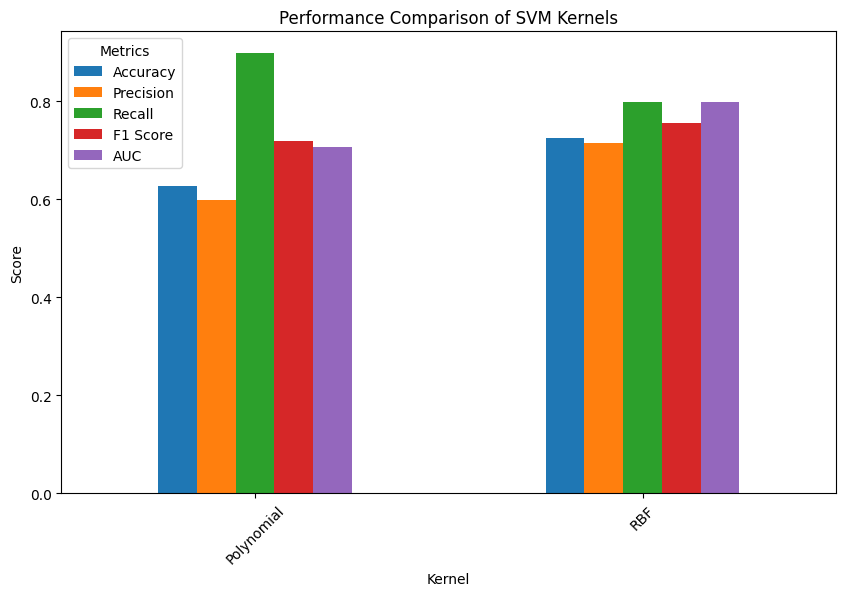

In [ ]:
# Function to evaluate the model and return performance metrics
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability of positive class

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)

    return accuracy, precision, recall, f1, auc

# Function to fit and evaluate the model
def fit_and_evaluate_model(kernel_type, best_params, X, y):
    svc_model = SVC(kernel=kernel_type, **best_params, probability=True)
    svc_model.fit(X, y)
    return evaluate_model(svc_model, X, y)

# Function to summarize results
def summarize_results(kernel_info):
    results_summary = pd.DataFrame(kernel_info)
    print("\nResults Summary:")
    print(results_summary)

# Function to visualize results
def visualize_results(results):
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    results.set_index('Kernel')[metrics].plot(kind='bar', figsize=(10, 6))
    plt.title('Performance Comparison of SVM Kernels')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Metrics')
    plt.show()

# Assuming X_selected and y are defined from previous steps
X_final = pd.DataFrame(X_selected)  # Ensure X_final is a DataFrame
y_final = y  # Target label variable

# Best parameters from previous tuning
best_params_poly = poly_best_params  # From previous tuning
best_params_rbf = rbf_best_params    # From previous tuning

# Evaluate models
poly_metrics = fit_and_evaluate_model('poly', best_params_poly, X_final, y_final)
rbf_metrics = fit_and_evaluate_model('rbf', best_params_rbf, X_final, y_final)

# Prepare data for results summary
kernel_info = {
    'Kernel': ['Polynomial', 'RBF'],
    'C': [best_params_poly['C'], best_params_rbf['C']],
    'Degree': [best_params_poly['degree'], '-'],
    'Gamma': [best_params_poly['gamma'], best_params_rbf['gamma']],
    'Accuracy': [round(poly_metrics[0], 4), round(rbf_metrics[0], 4)],
    'Precision': [round(poly_metrics[1], 4), round(rbf_metrics[1], 4)],
    'Recall': [round(poly_metrics[2], 4), round(rbf_metrics[2], 4)],
    'F1 Score': [round(poly_metrics[3], 4), round(rbf_metrics[3], 4)],
    'AUC': [round(poly_metrics[4], 4), round(rbf_metrics[4], 4)]
}

# Summarize results and visualize
summarize_results(kernel_info)
visualize_results(pd.DataFrame(kernel_info))

# Model Interpretation with LIME

In this section, we utilize LIME to provide local interpretability for our best-performing Support Vector Machine (SVM) model. LIME helps us understand the predictions made by the model by highlighting the contribution of individual features for a specific instance.

### Functions

1. **`create_lime_explainer(X)`**: This function initializes a LIME explainer using the training data `X`. It sets up the feature names and class names to be used in the explanations. The mode is specified as 'classification' since we are working with a classification problem.

2. **`explain_instance(explainer, model, instance)`**: This function takes the LIME explainer, the trained model, and a specific instance to explain. It returns an explanation of the model's prediction for that instance.

3. **`visualize_explanation(exp, instance_index)`**: This function visualizes the explanation generated by LIME. It displays both a table of the feature contributions and a plot showing how each feature impacts the model's prediction for the specified instance.

### Execution of LIME Explanation

1. **Best Model Selection**: The best-performing SVM model, which was previously identified (in this case, `rbf_svc`), is chosen for explanation.

2. **Creating LIME Explainer**: The LIME explainer is created using the final feature set `X_final`.

3. **Choosing an Instance**: An instance from the dataset is selected for explanation. The `instance_index` can be adjusted to explain different instances.

4. **Generating LIME Explanation**: The explanation for the selected instance is generated using the `explain_instance` function.

5. **Visualizing the Explanation**: Finally, the LIME explanation is visualized using the `visualize_explanation` function, which displays how each feature contributes to the model's prediction for the chosen instance.

<Figure size 1000x600 with 0 Axes>

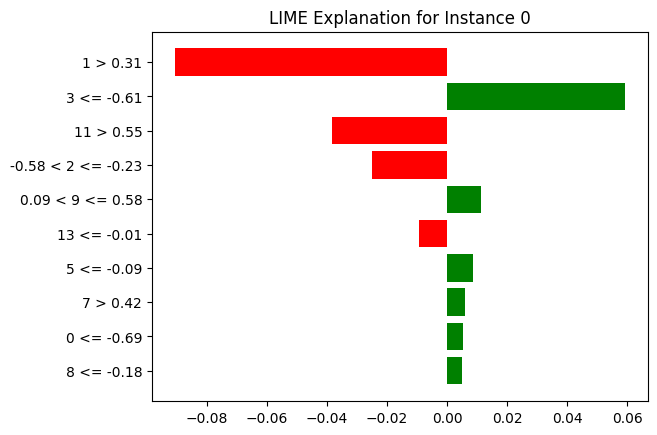

In [ ]:
# LIME for Explainability
def create_lime_explainer(X):
    return lime_tabular.LimeTabularExplainer(
        training_data=X.values,
        feature_names=X.columns.tolist(),
        class_names=['Class 0', 'Class 1'],  # Adjust as needed
        mode='classification'
    )

def explain_instance(explainer, model, instance):
    return explainer.explain_instance(
        data_row=instance.values,
        predict_fn=model.predict_proba
    )

def visualize_explanation(exp, instance_index):
    exp.show_in_notebook(show_table=True, show_all=False)
    
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Instance {instance_index}')
    plt.show()

# Choose the best-performing model (you can select based on metrics)
best_model = rbf_svc  # Replace with poly_svc if you found it better based on metrics

# Create LIME explainer
explainer = create_lime_explainer(X_final)

# Choose a single instance to explain
instance_index = 0  # Change this to explain different instances
instance_to_explain = X_final.iloc[instance_index]

# Generate LIME explanation
exp = explain_instance(explainer, best_model, instance_to_explain)

# Visualize the explanation
visualize_explanation(exp, instance_index)